In [1]:
from scipy.integrate import odeint
from scipy import arange, floor, exp
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
### Hodgekin-Huxley Model Class
class HH:
    ## Must be in same order as dXdt return
    label = ['V', 'm', 'h', 'n']
    nVar = len(label)

    ## Parameters
    p = {
    'C_m' : 1.0,
    'g_Na': 120.0,
    'g_K' : 36.0,
    'g_L' : 0.3,
    'E_Na': 50.0,
    'E_K' : -77.0,
    'E_L' : -54.387
    }

    ## Get initial values for the system
    def __init__(self, X0 = [-65, 0.05, 0.6, 0.32]):
        self.name = self.__class__.__name__
        if self.nVar != len(X0):
            print 'ERROR:', self.nVar, 'initial values required for:', self.name
        else: 
            self.X0 = X0
            
            
    ## External current (step function)
    def I_ext(self, t): return 10*floor(t/25)
         
    # Channel gating variables (ms)
    def alpha_m(self, V):  return 0.1*(V+40.0)/(1.0 - exp(-(V+40.0) / 10.0))
    def beta_m(self, V):   return 4.0*exp(-(V+65.0) / 18.0)
    def alpha_h(self, V):  return 0.07*exp(-(V+65.0) / 20.0)
    def beta_h(self, V):   return 1.0/(1.0 + exp(-(V+35.0) / 10.0))
    def alpha_n(self, V):  return 0.01*(V+55.0)/(1.0 - exp(-(V+55.0) / 10.0))
    def beta_n(self, V):   return 0.125*exp(-(V+65) / 80.0)

    # Membrane current (in uA/cm^2)
    def I_Na(self, V, m, h):  return self.p['g_Na'] * m**3 * h * (V - self.p['E_Na'])
    def I_K(self, V, n):      return self.p['g_K']  * n**4 * (V - self.p['E_K'])
    def I_L(self, V):         return self.p['g_L'] * (V - self.p['E_L'])

    
    ## Define the dX/dt for the system
    def dXdt(self, X, t):
        V, m, h, n = X

        dV = self.I_ext(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)/ self.p['C_m']
        dm = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dh = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dn = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n

        return dV, dm, dh, dn

In [18]:
## Time interval of the simulations
t = arange(0.0, 100.0, 0.01)
mm = HH()

## Solving the diffential equations
sol = odeint(mm.dXdt, mm.X0, t)

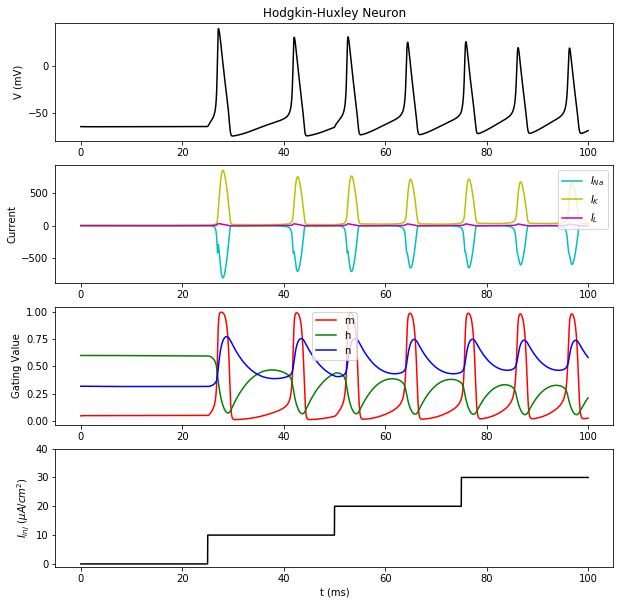

In [20]:
## Plot solution timeseries
V = sol[:,0]
m = sol[:,1]
h = sol[:,2]
n = sol[:,3]
ina = mm.I_Na(V, m, h)
ik = mm.I_K(V, n)
il = mm.I_L(V)

plt.figure(figsize=(10, 10))

plt.subplot(4,1,1)
plt.title('Hodgkin-Huxley Neuron')
plt.plot(t, V, 'k')
plt.ylabel('V (mV)')

plt.subplot(4,1,2)
plt.plot(t, ina, 'c', label='$I_{Na}$')
plt.plot(t, ik, 'y', label='$I_{K}$')
plt.plot(t, il, 'm', label='$I_{L}$')
plt.ylabel('Current')
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, m, 'r', label='m')
plt.plot(t, h, 'g', label='h')
plt.plot(t, n, 'b', label='n')
plt.ylabel('Gating Value')
plt.legend()

plt.subplot(4,1,4)
i_inj_values = [mm.I_ext(a) for a in t]
plt.plot(t, i_inj_values, 'k')
plt.xlabel('t (ms)')
plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
plt.ylim(-1, 40)

plt.show()